In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from hs2 import herdingspikes
from probe import NeuroPixel
from sklearn.cluster import DBSCAN

%matplotlib inline

In [2]:
# detectData(data, neighbours, spikefilename, shapefilename, channels, sfd, thres, maa = None, maxsl = None, minsl = None, ahpthr = None, tpre = 1, tpost = 2)
# MinAvgAmp minimal avg. amplitude of peak (in units of Qd)
# MaxSl dead time in frames after peak, used for further testing
# MinSl length considered for determining avg. spike amplitude
# AHPthr signal should go below that threshold within MaxSl-Slmin frames

user = "Cole"

if user == "Hennig":
    data_path = '/disk/scratch/mhennig/neuropixel/data/rawDataSample.bin'
elif user == "Martino":
    data_path = "data/rawDataSample.bin"
else:
    data_path = '/home/cole/neuropixeldata/rawDataSample.bin'

to_localize = True
cutout_start = 10
cutout_end = 30
threshold = 12
masking_channels = None#Can put a list of channel numbers you want masked
file_name = 'ProcessedSpikes'


In [3]:
Probe = NeuroPixel(data_file_path=data_path, fps=30000, masked_channels = masking_channels)

H = herdingspikes(Probe)

In [4]:
Probe.getChannelsPositions([323,326])

[array([  27, 3320]), array([  59, 3360])]

In [5]:
Probe.getChannelsPositions([324,323,325,322, 327])

[array([  43, 3340]),
 array([  27, 3320]),
 array([  11, 3340]),
 array([  59, 3320]),
 array([  27, 3360])]

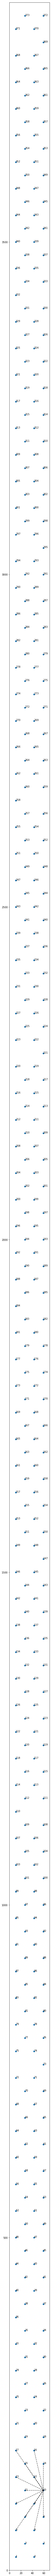

In [6]:
Probe.show()

In [7]:
H.DetectFromRaw(to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, file_path=file_name)

# # OR

#H.LoadDetected(file_name, cutout_length=cutout_end-cutout_start)

# Sampling rate: 30000
# Localization On
# Not Masking any Channels
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60.0
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 200000
# Analysing 200000 frames; -42 200055
# Analysing 200000 frames; 199958 400055
# Analysing 200000 frames; 399958 600055
# Analysing 200000 frames; 599958 800055
# Analysing 200000 frames; 799958 1000055
# Analysing 200000 frames; 999958 1200055
# Analysing 200000 frames; 1199958 1400055
# Analysing 200000 frames; 1399958 1600055
# Analysing 199945 frames; 1599958 1800000
# Time taken for detection: 0:00:24.535739
# Time per frame: 0:00:00.013631
# Time per sample: 0:00:00.000035
Detected and read 533310 spikes.


Spike detected at channel:  337
Spike detected at frame:  91


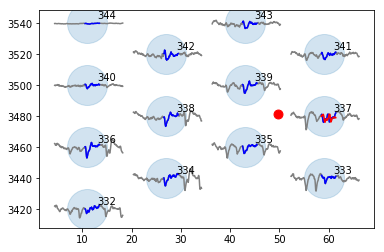

In [12]:
H.PlotTracesChannels(15)


In [5]:
spikes = []
with open("Detected Spikes") as dp:
    for i, line in enumerate(dp):
        line = line.rstrip('\n')
        line_tokens = line.split(' ')
        int_tokens = []
        for token in line_tokens:
            int_token = int(token)
            int_tokens.append(int_token)
        spikes.append((int_tokens))
        if i > 1000:
            break
print(spikes)

[[0, 10, 220317], [3, 17, 225878], [4, 17, 173845], [5, 17, 205585], [18, 26, 158906], [14, 28, 159196], [16, 28, 190486], [322, 28, 167819], [15, 29, 161058], [326, 29, 229652], [333, 42, 398140], [335, 42, 338596], [337, 42, 441847], [336, 43, 180769], [339, 43, 187173], [341, 44, 155417], [92, 46, 172306], [93, 46, 466558], [91, 47, 162433], [95, 47, 329953], [97, 47, 213810], [3, 64, 378412], [5, 65, 264258], [142, 67, 350757], [326, 69, 413840], [329, 69, 779623], [331, 69, 547673], [327, 70, 348538], [328, 70, 604421], [330, 70, 449407], [332, 70, 271378], [333, 70, 411498], [335, 70, 194981], [12, 84, 158852], [15, 84, 287285], [13, 85, 209205], [17, 86, 234087], [334, 89, 191683], [335, 89, 159701], [336, 90, 308188], [338, 90, 283091], [339, 90, 213409], [337, 91, 161501], [93, 101, 425640], [92, 102, 153159], [95, 102, 317849], [97, 102, 164551], [18, 112, 182742], [19, 112, 204122], [20, 112, 156275], [17, 113, 168498], [242, 115, 163025], [238, 118, 190100], [326, 118, 3304

In [6]:
import numpy as np
def findAverageFreq(spikes):
    start_frame = spikes[0][1]
    frame_average_amps = [[0,0], [0,0], [0,0], [0,0], [0,0], [0,0]]
    for spike in spikes:
        frame_difference = spike[1] - start_frame
        frame_average_amps[frame_difference][0] += spike[2]
        frame_average_amps[frame_difference][1] += 1
    return frame_average_amps
        

In [7]:
def findTotalAverageAmp(average_amps_list):
    total_amps = np.zeros(6)
    total_frequencies = np.zeros(6)
    for average_amps in average_amps_list:
        average_amp_array = np.zeros(6)
        for i, average_amp in enumerate(average_amps):
            if average_amp[1] != 0:
                average_amp_array[i] = average_amp[0]
                total_frequencies[i] += average_amp[1]
            else:
                average_amp_array[i] = 0
        total_amps = np.add(total_amps, average_amp_array)
    total_average_amp = np.zeros(6)    
    for i in range(6):
        if total_frequencies[i] == 0:
            total_average_amp[i] = 0
        else:
            total_average_amp[i] = total_amps[i]/total_frequencies[i]
            
    return total_average_amp

In [8]:
def findTotalAverageDecay(spikes_list):
    frame_average_amps = []
    for spikes in spikes_list:
        frame_average_amps.append(findAverageFreq(spikes))
    return findTotalAverageAmp(frame_average_amps)

In [9]:
alphabet = []
a = [spikes[4], spikes[5], spikes[6], spikes[8]]
alphabet.append(a)
b = [spikes[10], spikes[11], spikes[12], spikes[13], spikes[14], spikes[15]]
alphabet.append(b)
c = [spikes[16], spikes[17], spikes[18], spikes[19], spikes[20]]
alphabet.append(c)
d = [spikes[21], spikes[22]]
alphabet.append(d)
e = [spikes[33], spikes[34], spikes[35], spikes[36]]
alphabet.append(e)
f = [spikes[37], spikes[38], spikes[39], spikes[40], spikes[41]]
alphabet.append(f)
g = [spikes[43], spikes[44], spikes[45], spikes[46]]
alphabet.append(g)
h = [spikes[47], spikes[48], spikes[49], spikes[50]]
alphabet.append(h)
i = [spikes[51], spikes[52]]
alphabet.append(i)
j = [spikes[53], spikes[54], spikes[55]]
alphabet.append(j)
k = [spikes[56], spikes[57], spikes[58], spikes[59]]
alphabet.append(k)
l = [spikes[61], spikes[62], spikes[63]]
alphabet.append(l)
m = [spikes[64], spikes[65], spikes[66], spikes[67], spikes[68]]
alphabet.append(m)
n = [spikes[69], spikes[70], spikes[71]]
alphabet.append(n)
o = [spikes[72], spikes[73]]
alphabet.append(o)
p = [spikes[76], spikes[77]]
alphabet.append(p)
q = [spikes[78], spikes[79], spikes[80], spikes[81], spikes[83]]
alphabet.append(q)
r = [spikes[86], spikes[87], spikes[88], spikes[89]]
alphabet.append(r)
s = [spikes[104], spikes[105], spikes[106], spikes[107]]
alphabet.append(s)
t = [spikes[115], spikes[116], spikes[117]]
alphabet.append(t)
u = [spikes[118], spikes[119], spikes[121], spikes[123]]
alphabet.append(u)
v = [spikes[120], spikes[122], spikes[124], spikes[125]]
alphabet.append(v)
w = [spikes[82], spikes[84], spikes[85]]
alphabet.append(w)
x = [spikes[140], spikes[141], spikes[142], spikes[145], spikes[146], spikes[147], spikes[148]]
alphabet.append(x)
y = [spikes[166], spikes[167], spikes[168], spikes[169]]
alphabet.append(y)
z = [spikes[170], spikes[171]]
alphabet.append(z)
tad = findTotalAverageDecay(alphabet)

Text(0,0.5,'Decay (percentage)')

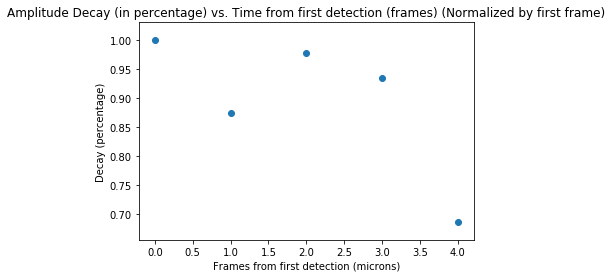

In [10]:
plt.scatter([0, 1, 2, 3, 4], tad[:5]/tad[0])
plt.title("Amplitude Decay (in percentage) vs. Time from first detection (frames) (Normalized by first frame)")
plt.xlabel("Frames from first detection (microns)")
plt.ylabel("Decay (percentage)")

In [12]:
def descendingAmps(spikes):
    descending_amps = sorted(spikes, key=lambda spike: -spike[2])
    return descending_amps

In [13]:
def getDistancesfromMax(positions):
    distances = []
    max_position = positions[0]
    for position in positions:
        distances.append(np.linalg.norm(max_position-position))
    return distances

In [14]:
def centerOfMass(positions, amps):
    X_numerator = 0
    Y_numerator = 0
    denominator = 0
    for i in range(len(amps)):
        curr_amp = amps[i]
        position = positions[i]
        X_coordinate = position[0]
        Y_coordinate = position[1]
        weight = curr_amp
        X_numerator += weight * X_coordinate
        Y_numerator += weight * Y_coordinate
        denominator += weight
    X = X_numerator / denominator
    Y = Y_numerator / denominator
    return [X, Y]

In [81]:
def getDecay(amplitudes):
    decay = []
    max_amp = amplitudes[0]
    for amplitude in amplitudes:
        #print(amplitude)
        #print(max_amp)
        #print(amplitude/max_amp)
        decay.append(amplitude/max_amp)
    return decay

In [82]:
def getDistancesfromCOM(com, positions):
    distances = []
    for position in positions:
        distances.append(np.linalg.norm(com-position))
    return distances

16
15
14
18
337
333
335
339
341


Text(0,0.5,'Decay (percentage)')

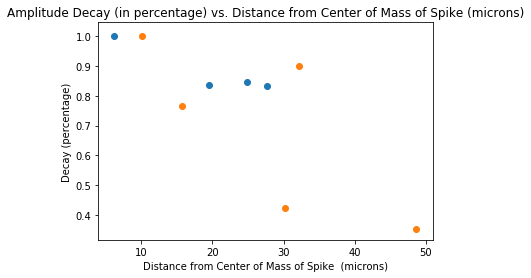

In [99]:
import numpy.polynomial.polynomial as poly

total_dists = []
for spikes in alphabet[:2]:
    amps = []
    channels = []
    for spike in descendingAmps(spikes):
        if spike[0] != 336:
            channels.append(spike[0])
            print(spike[0])
            amps.append(spike[2])
    positions = Probe.getChannelsPositions(channels)
    com = centerOfMass(positions, amps)
    dists = getDistancesfromCOM(com, positions)
    #dists = getDistancesfromMax(positions)
    #coefs = poly.polyfit(dists, getDecay(amps), 1)
    #ffit = poly.polyval(dists, coefs)
    plt.scatter(dists, getDecay(amps))
plt.title("Amplitude Decay (in percentage) vs. Distance from Center of Mass of Spike (microns)")
plt.xlabel("Distance from Center of Mass of Spike  (microns)")
plt.ylabel("Decay (percentage)")

Spike detected at channel:  337
Spike detected at frame:  42


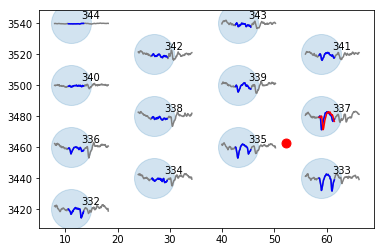

In [78]:
H.PlotTracesChannels(4)

In [ ]:
total_dists = []
for spikes in alphabet:
    amps = []
    channels = []
    for spike in descendingAmps(spikes):
        channels.append(spike[0])
        amps.append(spike[2])
    print(getDistancesfromMax(Probe.getChannelsPositions(channels)))
    print(getDecay(amps))
    plt.scatter(getDistancesfromMax(Probe.getChannelsPositions(channels)), getDecay(amps))
plt.scatter(distance_categories, percentage_list)
plt.title("Amplitude Decay (in percentage) vs. Distance from Max Spike (microns)")
plt.xlabel("Distance from Max Spike (microns)")
plt.ylabel("Decay (percentage)")

In [ ]:
total_dists = []
distance_categories = [0, 25.612496949731394, 32.0, 40.0, 52.0, 62.096698785040097, 86.16263691415206]
distance_percentages = [[0,0], [0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
for spikes in alphabet:
    amps = []
    channels = []
    for spike in descendingAmps(spikes):
        channels.append(spike[0])
        amps.append(spike[2])
    dists = getDistancesfromMax(Probe.getChannelsPositions(channels))
    decays = getDecay(amps)
    for i in range(len(decays)):
        if distance_categories[0] == dists[i]:
            distance_percentages[0][0] += decays[i]
            distance_percentages[0][1] += 1
        if distance_categories[1] == dists[i]:
            distance_percentages[1][0] += decays[i]
            distance_percentages[1][1] += 1
        if distance_categories[2] == dists[i]:
            distance_percentages[2][0] += decays[i]
            distance_percentages[2][1] += 1
        if distance_categories[3] == dists[i]:
            distance_percentages[3][0] += decays[i]
            distance_percentages[3][1] += 1
        if distance_categories[4] == dists[i]:
            distance_percentages[4][0] += decays[i]
            distance_percentages[4][1] += 1
        if distance_categories[5] == dists[i]:
            distance_percentages[5][0] += decays[i]
            distance_percentages[5][1] += 1
        if distance_categories[6] == dists[i]:
            distance_percentages[6][0] += decays[i]
            distance_percentages[6][1] += 1
print(distance_percentages)
percentage_list = []
for dp in distance_percentages:
    percentage = dp[0]/dp[1]
    percentage_list.append(percentage)

plt.scatter(distance_categories, percentage_list)
plt.title("Average Amplitude Decay (in percentage) vs. Distance from Max Spike (microns)")
plt.xlabel("Distance from Max Spike (microns)")
plt.ylabel("Average decay (percentage)")


In [ ]:
Probe.getChannelsPositions([0,1])